# Import required libraries

In [1]:
# import basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# import libraries to train and evaluate models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skmultilearn.problem_transform import ClassifierChain
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

# import libraries for different algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# import libraries to solve LP
from pulp import *

# Data preprocessing

Based on the description of the dataset: http://www.seaphe.org/databases/FOIA/lawschs_changelog_1_1.pdf and data preprocessing methods applied in https://www.mdpi.com/2306-5729/4/2/65/htm

College rankings are based on https://online.wsj.com/public/resources/documents/041510usnewslawrankings.pdf

In [2]:
# read data
df = pd.read_sas('law_school.sas7bdat')

# make all column names lowercase
df.columns = df.columns.str.lower()
 
# convert columns with `byte` data type
str_df = df.select_dtypes(['object'])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df[col] = str_df[col]    
    
# fill missing records in `lsat` and `gpa` with their medians
df.fillna({'gpa': df['gpa'].median(), 'lsat': df['lsat'].median()}, inplace = True)

# applicants with `admit` = 0 will also have `enroll` = 0
df.loc[(df['admit'] == 0) & (df['enroll'].isna()), 'enroll'] = 0

# remove missing records in `race`, `resident`, `college`, `gender`, `admit`, `enroll`
df = df[df[['race', 'resident', 'college', 'gender', 'admit', 'enroll']].notna().all(1)]

# remove outliers for LSAT and GPA
df = df[(df['lsat'] <= 180) & (df['lsat'] >= 120) & (df['gpa'] <= 4)]

# add tiers of universities in the order from df['college'].unique()
rankings = [38, 103, 42, 72, 60, 103, 103, 80, 9, 28, 140, 34,\
            78, 42, 103, 10, 28, 93, 103, 56, 93, 103, 22, 34]

# tiers of law schools based on rankings
tiers = []
for rank in rankings:
    if rank < 49:
        tiers.append('tier1')
    elif rank < 103:
        tiers.append('tier2')
    elif rank < 140:
        tiers.append('tier3')
    else:
        tiers.append('tier4')

# one-hot encoding for college tier
dummy_tier = pd.get_dummies(tiers, prefix='college', dtype = float)
college = pd.DataFrame(data = df['college'].unique(), columns = ['college'])
college = pd.merge(college, dummy_tier, left_index = True, right_index = True)
df = pd.merge(df, college, on='college', how='left')

# drop uneccessary columns
df.drop(['race', 'missingrace', 'urm', 'college', 'year'], axis = 1, inplace = True)

# rearrange order of columns
df.insert(len(df.columns)-1, 'admit', df.pop('admit'))
df.insert(len(df.columns)-1, 'enroll', df.pop('enroll'))

# output dataframe to csv for later usage
df.to_csv('clean_law_school.csv')

# Data summary

In [3]:
df

,lsat,gpa,resident,gender,black,hispanic,asian,white,college_tier1,college_tier2,college_tier3,college_tier4,admit,enroll
0,156.0,3.71,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,161.0,3.85,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,160.0,3.20,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,159.0,3.49,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,154.0,2.81,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97451,179.0,3.72,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
97452,179.0,3.96,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
97453,179.0,3.97,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
97454,180.0,3.29,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


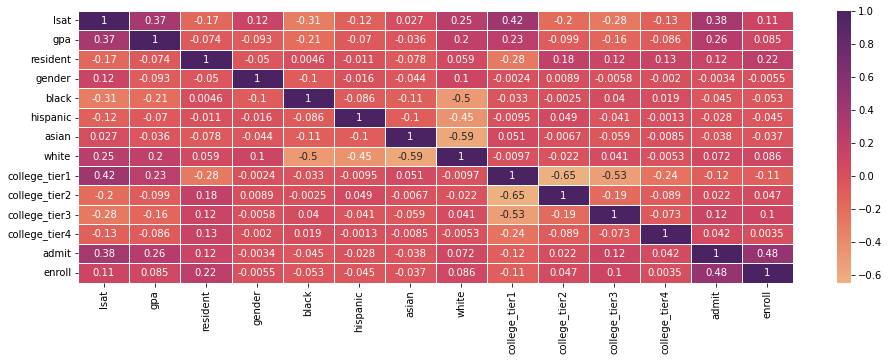

In [4]:
# generate correlation matrix heatmap
plt.figure(figsize = (16,5))
heatmap = sns.heatmap(data = df.corr(), annot = True, cmap = sns.color_palette("flare", as_cmap = True), linewidths = 1)

# Predict `admit` and `enroll`

### Background
To predict the result of `admit` and `enroll`, we can implement *Multi-label Classification*.

[Source](https://scikit-learn.org/stable/modules/multiclass.html#multilabel-classification)
> Multilabel classification (closely related to multioutput classification) is a classification task labeling each sample with m labels from n_classes possible classes, where m can be 0 to n_classes inclusive. This can be thought of as predicting properties of a sample that are not mutually exclusive. Formally, a binary output is assigned to each class, for every sample. Positive classes are indicated with 1 and negative classes with 0 or -1. It is thus comparable to running n_classes binary classification tasks, for example with MultiOutputClassifier. This approach treats each label independently whereas multilabel classifiers may treat the multiple classes **simultaneously, accounting for correlated behavior among them.**

Specifically, we use the *Classifier Chains* method to predict the two binary variables consequently since the result of `enroll` is **conditional** on the result of `admit` (that is, if `admit` is 0, then `enroll` must be 0).

[Source](https://scikit-learn.org/stable/modules/multiclass.html#classifierchain)
> Classifier chains are a way of combining a number of binary classifiers into a single multi-label model that is capable of exploiting correlations among targets.
For a multi-label classification problem with N classes, N binary classifiers are assigned an integer between 0 and N-1. These integers define the order of models in the chain. Each classifier is then fit on the available training data plus the true labels of the classes whose models were assigned a lower number.

### Implementation
References for choosing algorithms and metrics to evaluate them:

- https://www.mdpi.com/2306-5729/4/2/65/htm 

- Jesse Read, Bernhard Pfahringer, Geoff Holmes, Eibe Frank,
“Classifier Chains for Multi-label Classification”, 2009.

In [5]:
# split data into training and testing part
target = ['admit', 'enroll']
y = df[target]
X = df.drop(target, axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle = True, random_state = 1)

In [11]:
# define evaluation metrics: auc score (main), accuracy score, and f0.5 score
def score_auc(clf, X, y):
    y_score = clf.predict_proba(X)
    return roc_auc_score(y, y_score.toarray())

def score_accuracy(clf, X, y):
    y_score = clf.predict(X)
    return accuracy_score(y, y_score)

def score_fbeta(clf, X, y):
    y_score = clf.predict(X)
    return fbeta_score(y, y_score, beta = 0.5, average='weighted')

scoring = {'auc' : score_auc, 'accuracy': score_accuracy, 'fbeta': score_fbeta}

# train popular supervised algorithms and evaluate them using 10-fold cross validation
params = [
    {
        'classifier': [LogisticRegression(max_iter = 1000)],
    },
    {
        'classifier': [DecisionTreeClassifier()],
    },
    {
        'classifier': [RandomForestClassifier()],
    },
    {
        'classifier': [KNeighborsClassifier(n_neighbors = 10)],
    },
    {
        'classifier': [GaussianNB()],
    },
]

clf = GridSearchCV(ClassifierChain(), params, scoring = scoring, refit = 'auc', cv = 10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=ClassifierChain(require_dense=[True, True]),
             param_grid=[{'classifier': [LogisticRegression(max_iter=1000)]},
                         {'classifier': [DecisionTreeClassifier()]},
                         {'classifier': [RandomForestClassifier()]},
                         {'classifier': [KNeighborsClassifier(n_neighbors=10)]},
                         {'classifier': [GaussianNB()]}],
             refit='auc',
             scoring={'accuracy': <function score_accuracy at 0x7f5a76bf5b80>,
                      'auc': <function score_auc at 0x7f5a76bf5dc0>,
                      'fbeta': <function score_fbeta at 0x7f5a76bf5a60>})

### Performance evaluation of different algorithms

<AxesSubplot:xlabel='param_classifier'>

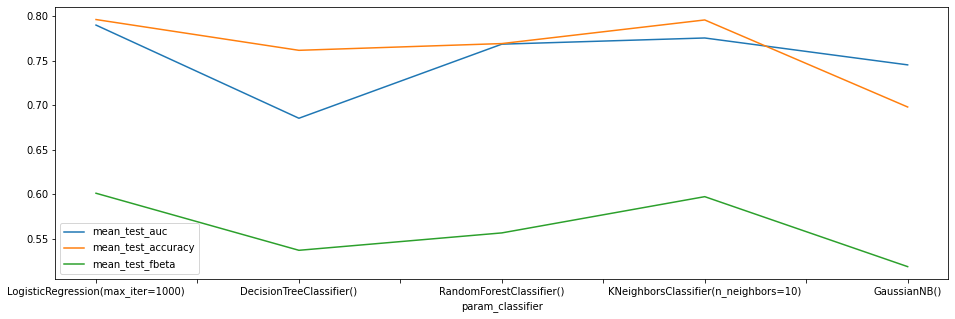

In [12]:
performance = pd.DataFrame(clf.cv_results_)
performance = performance[['param_classifier', 'mean_test_auc', 'rank_test_auc',\
                           'mean_test_accuracy', 'rank_test_accuracy', 'mean_test_fbeta',\
                           'rank_test_fbeta']]
performance.plot.line(x = 'param_classifier', y = ['mean_test_auc', 'mean_test_accuracy','mean_test_fbeta'], figsize = (16,5))

We can see that Logistic Regression provides the best performance in terms of auc score, f0.5 score and accuracy score.